# This is Notebook #1 with some fundamental examples

In [1]:
import duckdb
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from pypalettes import load_cmap
import json as json
import os

In [2]:
duckdb.sql("INSTALL spatial")
duckdb.sql("LOAD spatial")

# Load Openstreetmap-File
Derived by filtering the latest country file for Germany and filtering all "food & bevarage" amenities

The idea for this analysis was inspired by [a restaurant name trend analysis](https://surprisedatespot.com/blog/trends-in-restaurant-names).

In [40]:
gdf_cuisine = gpd.read_file('data/germany-latest-cuisine-merged.osm.pbf', layer='points')
gdf_cuisine.head()

,osm_id,name,barrier,highway,ref,address,is_in,place,man_made,other_tags,geometry
0,359460,Papa-Pizza,None,None,None,None,None,None,None,"""addr:city""=>""Köln"",""addr:country""=>""DE"",""addr...",POINT (6.94125 50.91559)
1,359832,Hartis Cafe,None,None,None,None,None,None,None,"""amenity""=>""restaurant"",""check_date""=>""2025-09...",POINT (6.96393 50.9052)
2,3325823,Grundmühle,None,None,None,None,None,None,None,"""amenity""=>""restaurant"",""opening_hours""=>""Mo-F...",POINT (13.65719 51.11308)
3,16257501,Subway,None,None,None,None,None,None,None,"""addr:city""=>""Weinheim"",""addr:country""=>""DE"",""...",POINT (8.65591 49.54964)
4,16257516,McDonald's,None,None,None,None,None,None,None,"""addr:city""=>""Weinheim"",""addr:country""=>""DE"",""...",POINT (8.6643 49.54869)


In [41]:
gdf_cuisine.describe()

,osm_id,name,barrier,highway,ref,address,is_in,place,man_made,other_tags,geometry
count,210877,200127,71,50,492,1,20,13,207,210823,210877
unique,210877,145266,8,8,445,1,17,3,16,179536,210854
top,359460,McDonald's,gate,street_lamp,53,"Am Heidebad 10, 06126 Halle (Saale)",Dülmen,locality,surveillance,"""amenity""=>""restaurant""",POINT (13.379272700000001 52.518346900000004)
freq,1,1368,39,29,5,1,3,7,157,3945,2


<Axes: >

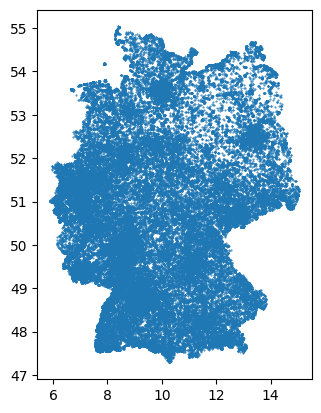

In [5]:
gdf_cuisine.plot(markersize=0.2)

In [42]:
# Set aside the geopandas dataframe for later use and convert it to a pandas dataframe for easier manipulation
df = gdf_cuisine.drop(['barrier', 'highway', 'address', 'is_in', 'place', 'man_made', 'ref'], axis=1)

# Build a JSON string to fascilitate the extraction of tags
df['tags'] = '{' + df['other_tags'].fillna('').astype(str).str.replace('=>', ':', regex=False) + '}'

# Extract specific tags of interest and drop the original tags columns
df['cuisine'] = df.apply(lambda x: json.loads(x['tags'], strict=False).get('cuisine', None), axis=1)
df['amenity'] = df.apply(lambda x: json.loads(x['tags'], strict=False).get('amenity', None), axis=1)
df = df.drop(['other_tags', 'tags'], axis=1)

df.head(10)

,osm_id,name,geometry,cuisine,amenity
0,359460,Papa-Pizza,POINT (6.94125 50.91559),pizza,fast_food
1,359832,Hartis Cafe,POINT (6.96393 50.9052),None,restaurant
2,3325823,Grundmühle,POINT (13.65719 51.11308),None,restaurant
3,16257501,Subway,POINT (8.65591 49.54964),sandwich,fast_food
4,16257516,McDonald's,POINT (8.6643 49.54869),burger,fast_food
5,16257541,Woinemer Hausbrauerei,POINT (8.66979 49.55372),german;regional,restaurant
6,16351361,Galileo,POINT (8.67566 49.55175),pizza,restaurant
7,16351362,Knuspergockel im Eulenspiegel,POINT (8.67488 49.55076),chicken,restaurant
8,16463584,Pizzeria Italia,POINT (8.67316 49.54927),italian,restaurant
9,16541937,McDonald's,POINT (12.78202 52.16048),burger,fast_food


In [43]:
df.groupby('amenity').size().sort_values(ascending=False).head(10)

amenity
restaurant          102932
fast_food            43216
cafe                 33652
pub                  16767
bar                   8584
vending_machine        119
toilets                 44
post_box                44
parking_entrance        11
atm                      7
dtype: int64

In [44]:
# Let's focus on restaurants
df_restaurants = df[df['amenity'] == 'restaurant']
df_restaurants.head()

,osm_id,name,geometry,cuisine,amenity
1,359832,Hartis Cafe,POINT (6.96393 50.9052),None,restaurant
2,3325823,Grundmühle,POINT (13.65719 51.11308),None,restaurant
5,16257541,Woinemer Hausbrauerei,POINT (8.66979 49.55372),german;regional,restaurant
6,16351361,Galileo,POINT (8.67566 49.55175),pizza,restaurant
7,16351362,Knuspergockel im Eulenspiegel,POINT (8.67488 49.55076),chicken,restaurant


In [45]:
df_restaurants_counts = df_restaurants.groupby('name').size()
df_restaurants_counts.sort_values(ascending=False).head(20)

name
Zur Linde           186
Akropolis           176
L'Osteria           172
Ratskeller          119
Poseidon            108
Schützenhaus        106
Adler                92
Grüner Baum          88
El Greco             88
Mensa                86
Hans im Glück        85
Taj Mahal            85
Zur Post             84
Delphi               82
Krone                81
Sportheim            79
Athen                79
Zur Krone            78
Gasthof zur Post     75
Deutsches Haus       75
dtype: int64

In [46]:
top_cuisine = (df_restaurants.groupby('cuisine')['name']
        .apply(lambda s: s.value_counts().nlargest(5))
        .reset_index(name='count')
        .sort_values(['cuisine','count'], ascending=[True, False]))
top_cuisine.head()

,cuisine,level_1,count
0,"""außer Donnerstags"" schnitzel; ""Nur Donnerstag...",Ponyhof,1
1,Balkan,Schwester Kumpir,1
2,Balkan,Retro Haus,1
3,"Burger, Steak, Pizza",LITON'S,1
4,Buschenschank,Weinhaus Hans-Peter Schwaab,1


In [47]:

keywords = [
    "see", "wald", "linde", "schützen", "ratskeller", "ratsstube",
    "adler", "baum", "post", "krone", "mühle", "hirsch", "sonne", "löwe", "rössl", "lamm",
    "kloster", "schänke", "keller", "krug", "traube", "ochse", "rose", "stern", 
    "jäger", "bürger", "bauer", "schwan", "schmied",
    "bier", "weinstube", "deutsch", "tanne", "bahnhof", "anker",
]

def classify_name(x):
    if pd.isna(x):
        return "Unnamed"
    lower = x.lower()
    for kw in keywords:
        if kw in lower:
            return kw.capitalize()
    return x
           
df_restaurants["name_class"] = df_restaurants["name"].apply(classify_name)
df_restaurants.head()

/workspaces/container-test-01/.venv/lib/python3.13/site-packages/geopandas/geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,osm_id,name,geometry,cuisine,amenity,name_class
1,359832,Hartis Cafe,POINT (6.96393 50.9052),None,restaurant,Hartis Cafe
2,3325823,Grundmühle,POINT (13.65719 51.11308),None,restaurant,Mühle
5,16257541,Woinemer Hausbrauerei,POINT (8.66979 49.55372),german;regional,restaurant,Woinemer Hausbrauerei
6,16351361,Galileo,POINT (8.67566 49.55175),pizza,restaurant,Galileo
7,16351362,Knuspergockel im Eulenspiegel,POINT (8.67488 49.55076),chicken,restaurant,Knuspergockel im Eulenspiegel


In [48]:
df_restaurants_class_counts = df_restaurants.groupby('name_class').size()
df_restaurants_class_counts.sort_values(ascending=False).head(20)

name_class
Unnamed      1536
Wald         1454
See          1154
Mühle         971
Linde         893
Post          658
Hirsch        585
Krone         565
Adler         543
Schänke       526
Sonne         490
Krug          475
Schützen      460
Löwe          397
Keller        363
Rose          357
Stern         342
Baum          319
Lamm          314
Weinstube     294
dtype: int64

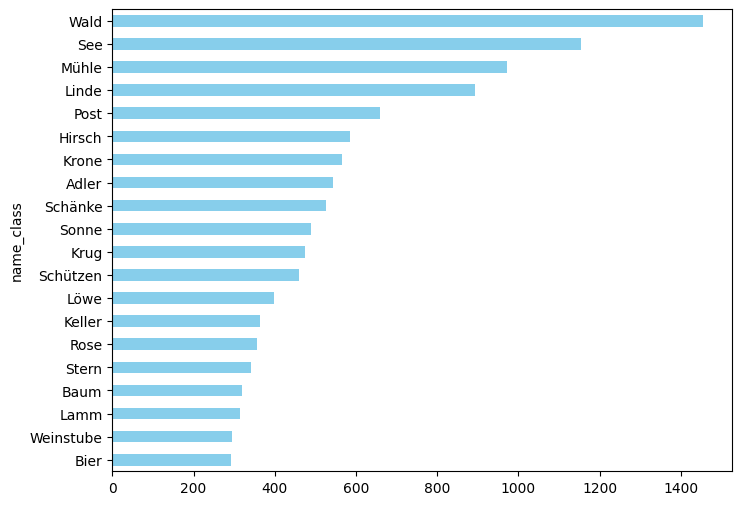

In [49]:
df_restaurants_class_counts.sort_values(ascending=False)[1:21].plot(kind='barh', figsize=(8, 6), color='skyblue')
plt.gca().invert_yaxis()
plt.show()

In [50]:
gdf_cuisine = gdf_cuisine.merge(df_restaurants[["osm_id", "name_class"]], left_on="osm_id", right_on="osm_id") 
gdf_cuisine.head(10)

,osm_id,name,barrier,highway,ref,address,is_in,place,man_made,other_tags,geometry,name_class
0,359832,Hartis Cafe,None,None,None,None,None,None,None,"""amenity""=>""restaurant"",""check_date""=>""2025-09...",POINT (6.96393 50.9052),Hartis Cafe
1,3325823,Grundmühle,None,None,None,None,None,None,None,"""amenity""=>""restaurant"",""opening_hours""=>""Mo-F...",POINT (13.65719 51.11308),Mühle
2,16257541,Woinemer Hausbrauerei,None,None,None,None,None,None,None,"""addr:city""=>""Weinheim"",""addr:country""=>""DE"",""...",POINT (8.66979 49.55372),Woinemer Hausbrauerei
3,16351361,Galileo,None,None,None,None,None,None,None,"""addr:city""=>""Weinheim"",""addr:country""=>""DE"",""...",POINT (8.67566 49.55175),Galileo
4,16351362,Knuspergockel im Eulenspiegel,None,None,None,None,None,None,None,"""addr:city""=>""Weinheim"",""addr:country""=>""DE"",""...",POINT (8.67488 49.55076),Knuspergockel im Eulenspiegel
5,16463584,Pizzeria Italia,None,None,None,None,None,None,None,"""addr:city""=>""Weinheim"",""addr:country""=>""DE"",""...",POINT (8.67316 49.54927),Pizzeria Italia
6,18087087,Huong Viet,None,None,None,None,None,None,None,"""amenity""=>""restaurant"",""cuisine""=>""vietnamese...",POINT (11.75671 48.16223),Huong Viet
7,20090856,Zum Oberbräu,None,None,None,None,None,None,None,"""addr:city""=>""Holzkirchen"",""addr:country""=>""DE...",POINT (11.70109 47.87723),Zum Oberbräu
8,21294583,Alte Feuerwache,None,None,None,None,None,None,None,"""air_conditioning""=>""no"",""amenity""=>""restauran...",POINT (11.45724 50.10792),Alte Feuerwache
9,21294591,Pizzeria Faessla,None,None,None,None,None,None,None,"""air_conditioning""=>""no"",""amenity""=>""restauran...",POINT (11.45668 50.10929),Pizzeria Faessla


<Axes: >

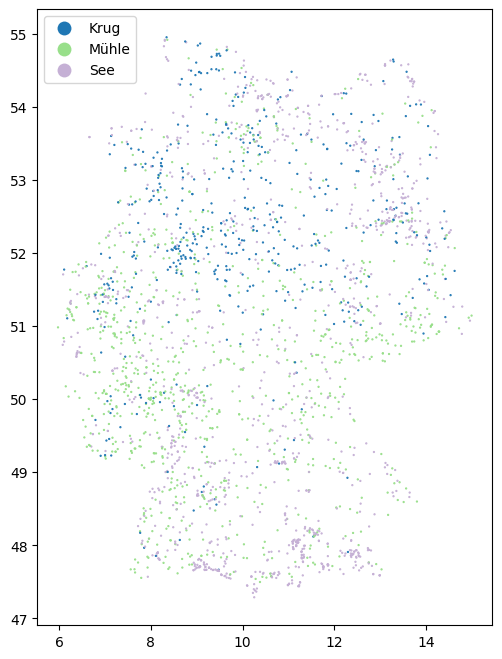

In [51]:
#gdf_names = gdf_cuisine[gdf_cuisine["name_class"].isin(["Wald", "See", "Mühle", "Linde", "Post", "Krone"])]
gdf_names = gdf_cuisine[gdf_cuisine["name_class"].isin(["See", "Krug", "Mühle"])]
gdf_names.plot(column='name_class', markersize=0.4, legend=True, figsize=(12, 8), cmap=load_cmap("tab20"))


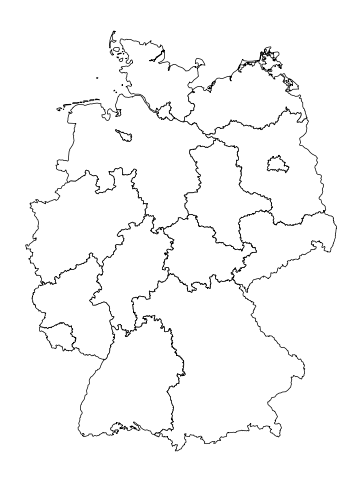

In [52]:
gdf_lan = gpd.read_file('data/vg5000_12-31.utm32s.shape.ebenen/vg5000_ebenen_1231/VG5000_LAN.shp')
gdf_lan = gdf_lan[gdf_lan["GF"]==9]
#gdf_lan.head(20)
gdf_lan.plot(color='white', edgecolor='black', linewidth=0.5,figsize=(8, 6))
plt.axis('off')
plt.show()

In [53]:
gdf_lan = gdf_lan.to_crs(4326)
gdf_lan = gdf_lan[["GEN", "geometry"]]
gdf_cuisine = gdf_cuisine.sjoin(gdf_lan, how="inner", predicate="intersects")
gdf_cuisine.head()

,osm_id,name,barrier,highway,ref,address,is_in,place,man_made,other_tags,geometry,name_class,index_right,GEN
0,359832,Hartis Cafe,None,None,None,None,None,None,None,"""amenity""=>""restaurant"",""check_date""=>""2025-09...",POINT (6.96393 50.9052),Hartis Cafe,4,Nordrhein-Westfalen
1,3325823,Grundmühle,None,None,None,None,None,None,None,"""amenity""=>""restaurant"",""opening_hours""=>""Mo-F...",POINT (13.65719 51.11308),Mühle,13,Sachsen
2,16257541,Woinemer Hausbrauerei,None,None,None,None,None,None,None,"""addr:city""=>""Weinheim"",""addr:country""=>""DE"",""...",POINT (8.66979 49.55372),Woinemer Hausbrauerei,7,Baden-Württemberg
3,16351361,Galileo,None,None,None,None,None,None,None,"""addr:city""=>""Weinheim"",""addr:country""=>""DE"",""...",POINT (8.67566 49.55175),Galileo,7,Baden-Württemberg
4,16351362,Knuspergockel im Eulenspiegel,None,None,None,None,None,None,None,"""addr:city""=>""Weinheim"",""addr:country""=>""DE"",""...",POINT (8.67488 49.55076),Knuspergockel im Eulenspiegel,7,Baden-Württemberg


In [54]:
# gdf_cuisine.head()
# gdf_cuisine.groupby(['GEN', 'name_class']).size().head(5)
# gdf_cuisine.groupby(['GEN', 'name_class']).size().sort_values(ascending=False).head(20)

gdf_cuisine = gdf_cuisine[gdf_cuisine['name_class'] != 'Unnamed']

top3 = (gdf_cuisine.groupby('GEN')['name_class']
        .apply(lambda s: s.value_counts().nlargest(5))
        .reset_index(name='count')
        .sort_values(['GEN','count'], ascending=[True, False]))
top3.head(100)

,GEN,level_1,count
0,Baden-Württemberg,Wald,311
1,Baden-Württemberg,Hirsch,292
2,Baden-Württemberg,Adler,286
3,Baden-Württemberg,Krone,245
4,Baden-Württemberg,Sonne,187
...,...,...,...
75,Thüringen,Wald,95
76,Thüringen,Linde,66
77,Thüringen,Mühle,44
78,Thüringen,Schänke,31


<Axes: >

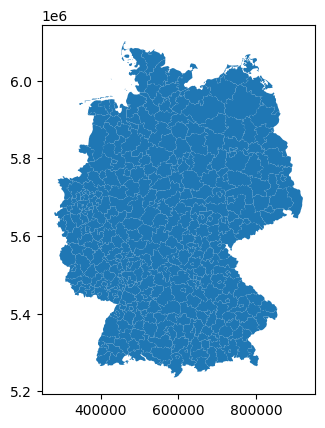

In [55]:
gdf_krs = gpd.read_file('data/vg2500_12-31.utm32s.shape/vg2500/VG2500_KRS.shp')
gdf_krs.plot()

In [67]:
gdf_krs.head()

,OBJID,BEGINN,ADE,GF,BSG,LKZ,ARS,AGS,SDV_ARS,GEN,...,SN_K,SN_V1,SN_V2,SN_G,FK_S3,NUTS,ARS_0,AGS_0,WSK,geometry
0,DEBKGVG300000004,2021-09-01,4,9,1,SH,01001,01001,010010000000,Flensburg,...,01,00,00,000,R,DEF01,010010000000,01001000,2008-01-01,"POLYGON ((531470.957 6075201.09, 532435.433 60..."
1,DEBKGVG300000005,2021-09-01,4,9,1,SH,01002,01002,010020000000,Kiel,...,02,00,00,000,R,DEF02,010020000000,01002000,2006-01-01,"POLYGON ((577310.28 6027466.911, 576863.752 60..."
2,DEBKGVG300000006,2021-09-01,4,9,1,SH,01003,01003,010030000000,Lübeck,...,03,00,00,000,R,DEF03,010030000000,01003000,2006-02-01,"POLYGON ((624204.438 5980391.723, 624886.676 5..."
3,DEBKGVG300000007,2021-09-01,4,9,1,SH,01004,01004,010040000000,Neumünster,...,04,00,00,000,R,DEF04,010040000000,01004000,1970-04-26,"POLYGON ((567602.493 5998385.945, 566865.243 5..."
4,DEBKGVG300000008,2021-09-01,4,9,1,SH,01051,01051,010510044044,Dithmarschen,...,51,00,00,000,R,DEF05,010510000000,01051000,2011-08-01,"MULTIPOLYGON (((479551.742 5990180.683, 479871..."


In [68]:
df_pop = pd.read_csv('data/12411-0016_de.csv', skiprows=7, sep=';', names=['KRS_ID', 'KRS_NAME', 'pop_m', 'pop_m_q', 'pop_f', 'pop_f_q', 'pop', 'pop_q'])
df_pop = df_pop[df_pop['pop_q'] == 'e']
df_pop = df_pop.astype({'pop': "int32"})
df_pop.head()

,KRS_ID,KRS_NAME,pop_m,pop_m_q,pop_f,pop_f_q,pop,pop_q
0,01001,"Flensburg, kreisfreie Stadt",47651,e,48675,e,96326,e
1,01002,"Kiel, kreisfreie Stadt",123532,e,129136,e,252668,e
2,01003,"Lübeck, kreisfreie Stadt",104309,e,112580,e,216889,e
3,01004,"Neumünster, kreisfreie Stadt",39742,e,40067,e,79809,e
4,01051,"Dithmarschen, Landkreis",65838,e,67622,e,133460,e


In [69]:
gdf_krs_pop = gdf_krs.merge(df_pop, left_on='AGS', right_on='KRS_ID')
gdf_krs_pop.head()

,OBJID,BEGINN,ADE,GF,BSG,LKZ,ARS,AGS,SDV_ARS,GEN,...,WSK,geometry,KRS_ID,KRS_NAME,pop_m,pop_m_q,pop_f,pop_f_q,pop,pop_q
0,DEBKGVG300000004,2021-09-01,4,9,1,SH,01001,01001,010010000000,Flensburg,...,2008-01-01,"POLYGON ((531470.957 6075201.09, 532435.433 60...",01001,"Flensburg, kreisfreie Stadt",47651,e,48675,e,96326,e
1,DEBKGVG300000005,2021-09-01,4,9,1,SH,01002,01002,010020000000,Kiel,...,2006-01-01,"POLYGON ((577310.28 6027466.911, 576863.752 60...",01002,"Kiel, kreisfreie Stadt",123532,e,129136,e,252668,e
2,DEBKGVG300000006,2021-09-01,4,9,1,SH,01003,01003,010030000000,Lübeck,...,2006-02-01,"POLYGON ((624204.438 5980391.723, 624886.676 5...",01003,"Lübeck, kreisfreie Stadt",104309,e,112580,e,216889,e
3,DEBKGVG300000007,2021-09-01,4,9,1,SH,01004,01004,010040000000,Neumünster,...,1970-04-26,"POLYGON ((567602.493 5998385.945, 566865.243 5...",01004,"Neumünster, kreisfreie Stadt",39742,e,40067,e,79809,e
4,DEBKGVG300000008,2021-09-01,4,9,1,SH,01051,01051,010510044044,Dithmarschen,...,2011-08-01,"MULTIPOLYGON (((479551.742 5990180.683, 479871...",01051,"Dithmarschen, Landkreis",65838,e,67622,e,133460,e


<Axes: >

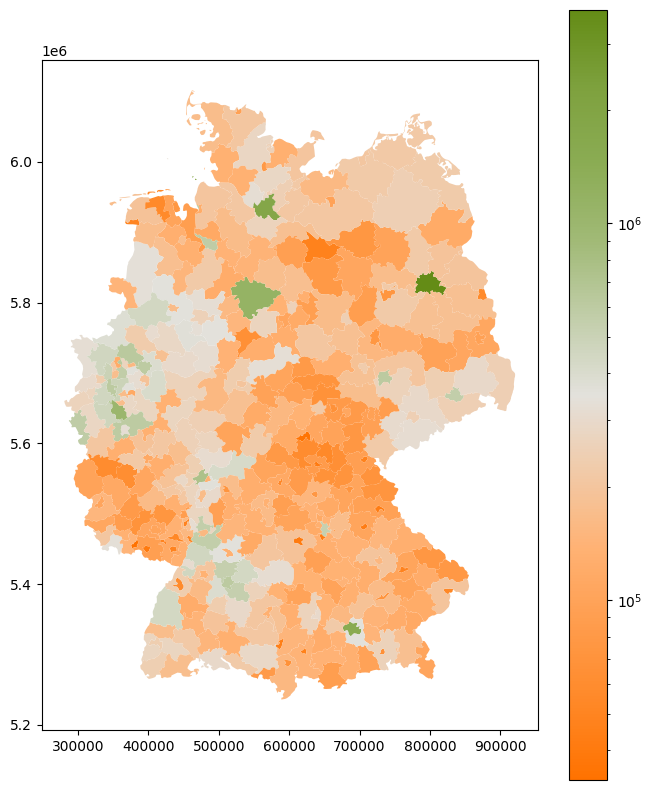

In [59]:
#df_pop['pop'].min(), df_pop['pop'].max()
cmap = load_cmap("Avedon", cmap_type="continuous")  # "BrwnYl" is a brown-yellow color scheme
gdf_krs_pop.plot(figsize=(8,10) , column='pop', legend=True, cmap=cmap, norm=pltc.LogNorm(vmin=df_pop['pop'].min(), vmax=df_pop['pop'].max()))

# Source - https://stackoverflow.com/a/63907917
# Posted by martinfleis
# Retrieved 2026-02-10, License - CC BY-SA 4.0
# world.plot(column='pop_est', legend=True, norm=matplotlib.colors.LogNorm(vmin=world.pop_est.min(), vmax=world.pop_est.max()), )


In [ ]:
#gdf_cuisine = gdf_cuisine.drop(['barrier', 'highway', 'address', 'is_in', 'place', 'man_made', 'ref'], axis=1)
gdf_krs_pop = gdf_krs_pop.to_crs(4326)
gdf_krs_pop = gdf_krs_pop[["KRS_ID", "GEN", "geometry", "pop"]]
df = df.drop(['index_right'], axis=1)
df = gpd.sjoin(df, gdf_krs_pop, how="inner", predicate="intersects")
df.head()


,osm_id,name,geometry,cuisine,amenity,GEN_left,pop_left,index_right,KRS_ID,GEN_right,pop_right
0,359460,Papa-Pizza,POINT (6.94125 50.91559),pizza,fast_food,Köln,1024621,79,05315,Köln,1024621
1,359832,Hartis Cafe,POINT (6.96393 50.9052),None,restaurant,Köln,1024621,79,05315,Köln,1024621
2,3325823,Grundmühle,POINT (13.65719 51.11308),None,restaurant,Meißen,239221,359,14627,Meißen,239221
3,16257501,Subway,POINT (8.65591 49.54964),sandwich,fast_food,Rhein-Neckar-Kreis,558561,198,08226,Rhein-Neckar-Kreis,558561
4,16257516,McDonald's,POINT (8.6643 49.54869),burger,fast_food,Rhein-Neckar-Kreis,558561,198,08226,Rhein-Neckar-Kreis,558561


In [81]:
top_krs_cuisine = (df.groupby('KRS_ID')['cuisine']
        .apply(lambda s: s.value_counts().nlargest(1))
        .reset_index(name='count')
        .sort_values(['KRS_ID','count'], ascending=[True, False]))
top_krs_cuisine.head(100)

,KRS_ID,level_1,count
0,01001,greek,12
1,01002,kebab,39
2,01003,italian,33
3,01004,burger,9
4,01051,regional,15
...,...,...,...
95,05566,german,72
96,05570,german,27
97,05711,pizza,36
98,05754,german,35


In [82]:
gdf_krs_cuisine = gdf_krs.merge(top_krs_cuisine, left_on='AGS', right_on='KRS_ID')
gdf_krs_cuisine.head()

,OBJID,BEGINN,ADE,GF,BSG,LKZ,ARS,AGS,SDV_ARS,GEN,...,SN_G,FK_S3,NUTS,ARS_0,AGS_0,WSK,geometry,KRS_ID,level_1,count
0,DEBKGVG300000004,2021-09-01,4,9,1,SH,01001,01001,010010000000,Flensburg,...,000,R,DEF01,010010000000,01001000,2008-01-01,"POLYGON ((531470.957 6075201.09, 532435.433 60...",01001,greek,12
1,DEBKGVG300000005,2021-09-01,4,9,1,SH,01002,01002,010020000000,Kiel,...,000,R,DEF02,010020000000,01002000,2006-01-01,"POLYGON ((577310.28 6027466.911, 576863.752 60...",01002,kebab,39
2,DEBKGVG300000006,2021-09-01,4,9,1,SH,01003,01003,010030000000,Lübeck,...,000,R,DEF03,010030000000,01003000,2006-02-01,"POLYGON ((624204.438 5980391.723, 624886.676 5...",01003,italian,33
3,DEBKGVG300000007,2021-09-01,4,9,1,SH,01004,01004,010040000000,Neumünster,...,000,R,DEF04,010040000000,01004000,1970-04-26,"POLYGON ((567602.493 5998385.945, 566865.243 5...",01004,burger,9
4,DEBKGVG300000008,2021-09-01,4,9,1,SH,01051,01051,010510044044,Dithmarschen,...,000,R,DEF05,010510000000,01051000,2011-08-01,"MULTIPOLYGON (((479551.742 5990180.683, 479871...",01051,regional,15


<Axes: >

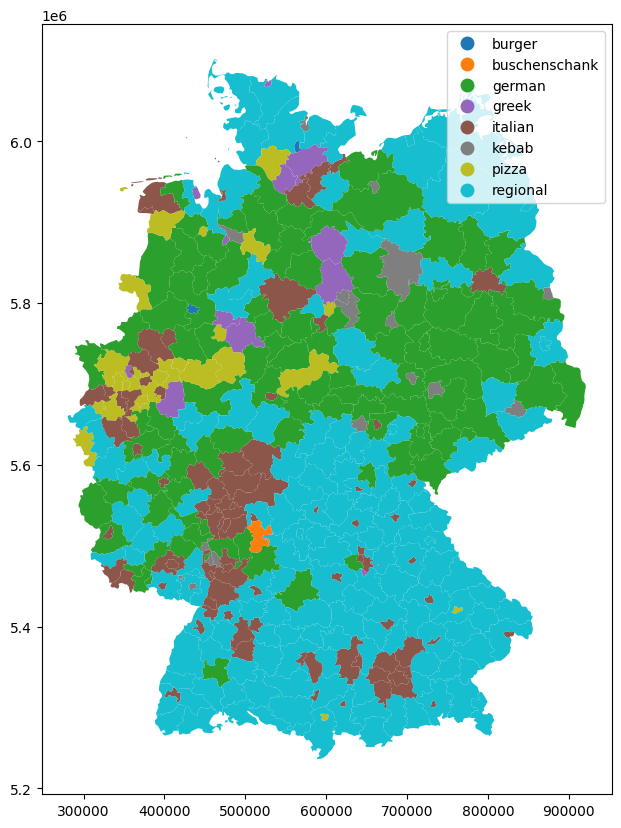

In [84]:
gdf_krs_cuisine.plot(figsize=(8,10) , column='level_1', legend=True)